# Imports & Settings

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting the default styling attributes for seaborn
sns.set_theme(style='darkgrid')

In [3]:
# Loading in the dataset
df = pd.read_csv('weatherAUS.csv')

# Exploratory Data Analysis

# Data Preview


In [4]:
df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

# Column Definitions

According to the author of the Kaggle dataset and the "Notes to accompany Daily Weather Observations" published by the Australian Bureau of Meteorology, the meanings and units for each of the columns in the dataset are as follows:

# Exploration

# Summary Info and Stats


Taking a look at the dataframe info:



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           8425 non-null   object 
 1   Location       8425 non-null   object 
 2   MinTemp        8350 non-null   float64
 3   MaxTemp        8365 non-null   float64
 4   Rainfall       8185 non-null   float64
 5   Evaporation    4913 non-null   float64
 6   Sunshine       4431 non-null   float64
 7   WindGustDir    7434 non-null   object 
 8   WindGustSpeed  7434 non-null   float64
 9   WindDir9am     7596 non-null   object 
 10  WindDir3pm     8117 non-null   object 
 11  WindSpeed9am   8349 non-null   float64
 12  WindSpeed3pm   8318 non-null   float64
 13  Humidity9am    8366 non-null   float64
 14  Humidity3pm    8323 non-null   float64
 15  Pressure9am    7116 non-null   float64
 16  Pressure3pm    7113 non-null   float64
 17  Cloud9am       6004 non-null   float64
 18  Cloud3pm

# Observations:

* The Date column needs converted to a datetime datatype
* The datatypes for all other columns look good as is
* There appears to be a large number of missing values across multiple columns
* Looking into the number of missing values per column as a percentage:

In [7]:
round(df.isna().sum() / len(df), 3)

Date             0.000
Location         0.000
MinTemp          0.009
MaxTemp          0.007
Rainfall         0.028
Evaporation      0.417
Sunshine         0.474
WindGustDir      0.118
WindGustSpeed    0.118
WindDir9am       0.098
WindDir3pm       0.037
WindSpeed9am     0.009
WindSpeed3pm     0.013
Humidity9am      0.007
Humidity3pm      0.012
Pressure9am      0.155
Pressure3pm      0.156
Cloud9am         0.287
Cloud3pm         0.291
Temp9am          0.007
Temp3pm          0.011
RainToday        0.028
RainTomorrow     0.028
dtype: float64

# Observations:

* Evaporation, Sunshine, Cloud9am, and Cloud3pm are all missing more than 35% of their values
* Aside from Date and Location, all columns are missing at least some values
* These missing values can be handled by either dropping certain columns/rows, imputing the values, or a mix of both
Next, taking a look at some summary statistics:

In [8]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,8350.000000,8365.000000,8185.000000,4913.000000,4431.000000,7434.000000,8349.000000,8318.000000,8366.000000,8323.000000,7116.000000,7113.000000,6004.000000,5970.000000,8369.000000,8329.000000
mean,13.193305,23.859976,2.805913,5.389395,7.632205,40.174469,13.847646,18.533662,67.822496,51.249790,1017.640233,1015.236075,4.566622,4.503183,17.762015,22.442934
std,5.403596,6.136408,10.459379,5.044484,3.896235,14.665721,10.174579,9.766986,16.833283,18.423774,6.828699,6.766681,2.877658,2.731659,5.627035,5.980020
min,-2.000000,8.200000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,10.000000,6.000000,989.800000,982.900000,0.000000,0.000000,1.900000,7.300000
25%,9.200000,19.300000,0.000000,2.600000,4.750000,30.000000,6.000000,11.000000,56.000000,39.000000,1013.000000,1010.400000,1.000000,2.000000,13.800000,18.000000
50%,13.300000,23.300000,0.000000,4.600000,8.700000,39.000000,13.000000,19.000000,68.000000,51.000000,1017.700000,1015.300000,5.000000,5.000000,17.800000,21.900000
75%,17.400000,28.000000,1.000000,7.000000,10.700000,50.000000,20.000000,24.000000,80.000000,63.000000,1022.300000,1019.800000,7.000000,7.000000,21.900000,26.400000
max,28.500000,45.500000,371.000000,145.000000,13.900000,107.000000,63.000000,83.000000,100.000000,99.000000,1039.000000,1036.000000,8.000000,8.000000,39.400000,44.100000


# Observations:

* Multiple columns have clear outliers (e.g., the max Rainfall value is 371.0 despite the 75th percentile being 0.8)
* Not seeing any values that are immediate cause for concern (such as a negative value for minimum Rainfall)


In order to get a better feel for the data and catch any placeholder values that may not have shown up in the summary statistics, I also want to check the top five most frequent values for each column.

In [9]:
for col in df.columns:
    print('\n')
    print(col)
    print('-'*15)
    print(df[col].value_counts(normalize=True).head())



Date
---------------
2011-01-31    0.000593
2011-05-08    0.000593
2011-05-21    0.000593
2011-05-20    0.000593
2011-05-19    0.000593
Name: Date, dtype: float64


Location
---------------
Melbourne       0.192522
Williamtown     0.145994
PerthAirport    0.142908
Albury          0.107656
Newcastle       0.097567
Name: Location, dtype: float64


MinTemp
---------------
12.0    0.008862
13.2    0.008503
13.8    0.008263
12.7    0.008144
16.4    0.008024
Name: MinTemp, dtype: float64


MaxTemp
---------------
19.0    0.010400
23.8    0.008966
19.8    0.008846
25.0    0.008488
22.0    0.008129
Name: MaxTemp, dtype: float64


Rainfall
---------------
0.0    0.647404
0.2    0.049603
0.4    0.021625
0.6    0.014172
1.2    0.010507
Name: Rainfall, dtype: float64


Evaporation
---------------
4.0    0.036637
3.0    0.033177
2.4    0.029921
2.2    0.029717
2.6    0.029106
Name: Evaporation, dtype: float64


Sunshine
---------------
0.0     0.037463
11.1    0.015346
11.2    0.015121
11.0    0.

# Observations:

* The value counts of the Date column need further explored on a non-normalized basis
* There's a disconnect between the Rainfall value counts and the RainToday / RainTomorrow value counts. While roughly 64% of observations had a value of 0 for Rainfall, about 77.5% of days did not have rainfall according to the latter two columns. This discrepency is likely due to differences in the number of missing values for each column
* The RainToday and RainTomorrow columns should be converted to 0s and 1s for easier manipulation
Further exploring the Date column:

In [10]:
df.Date.value_counts()

2011-01-31    5
2011-05-08    5
2011-05-21    5
2011-05-20    5
2011-05-19    5
             ..
2013-01-28    1
2013-01-29    1
2013-01-30    1
2013-01-31    1
2013-06-08    1
Name: Date, Length: 3004, dtype: int64

In [11]:
df.Location.nunique()

12

The maximum number of observations for a given date aligns with the number of unique locations within the dataset. This intuitively makes sense because each weather station at the different locations would be reporting their own data for a given day.

Adjusting the RainToday and RainTomorrow columns:

In [12]:
df.RainToday = df.RainToday.map({'No': 0, 'Yes': 1})
df.RainToday.value_counts(normalize=True)

0.0    0.756872
1.0    0.243128
Name: RainToday, dtype: float64

In [13]:
df.RainTomorrow = df.RainTomorrow.map({'No': 0, 'Yes': 1})
df.RainTomorrow.value_counts(normalize=True)

0.0    0.75678
1.0    0.24322
Name: RainTomorrow, dtype: float64

# Histograms


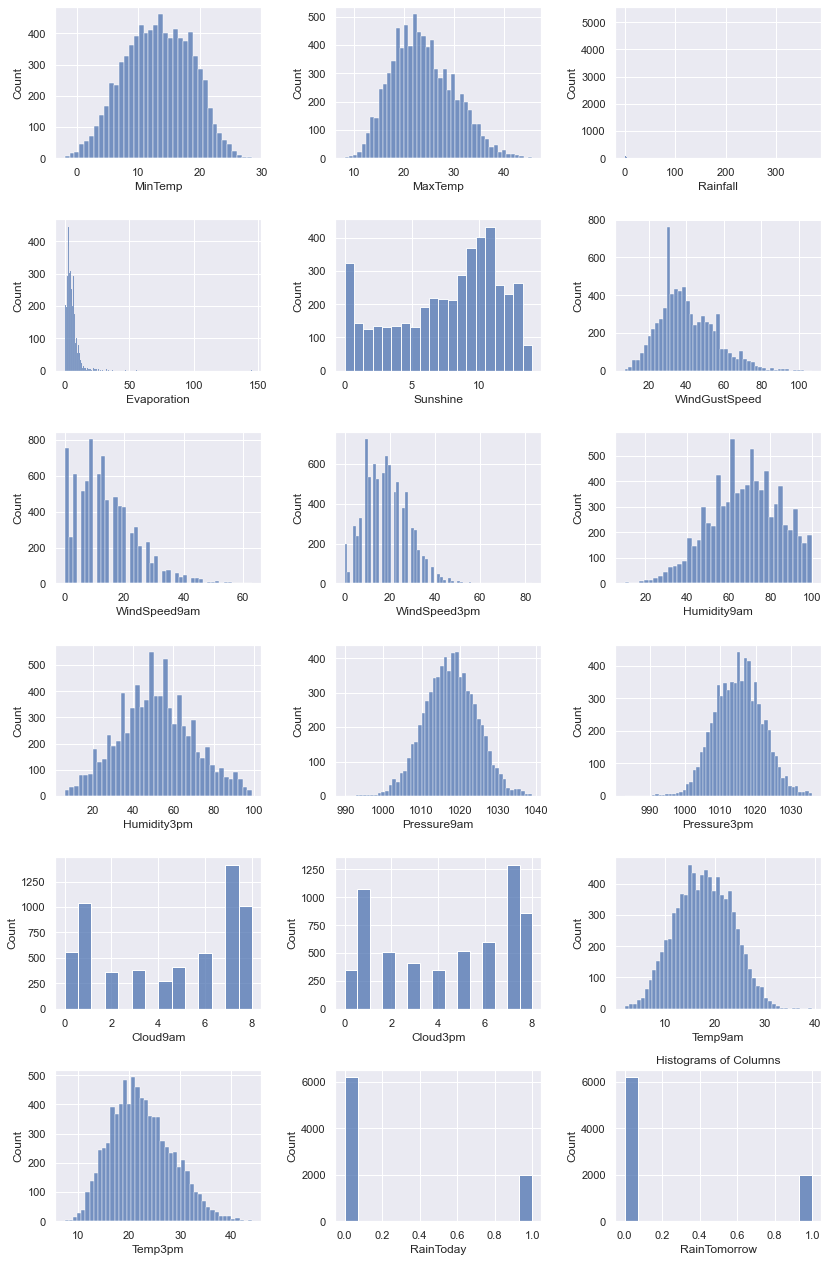

In [86]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 18))
axes = axes.reshape(-1)

continuous = [col for col in df.columns if df[col].dtype != object]
for i, col in enumerate(continuous):
    sns.histplot(df[col], ax=axes[i])

fig.tight_layout(pad=2.0)
plt.title('Histograms of Columns')
plt.savefig('images', facecolor='white', dpi=100);

# Observations:

* Most features are normally distributed as expected
* The Rainfall distribution needs further investigation as the large outlier is likely affecting the ability to plot the data
* The Sunshine distribution is interesting but largely explainable:
    * The high frequency of 0 values represents days where it is overcast all day
    * The abrupt decline in frequency after around 11 hours is a reflection of the limited number of days of the year where it is light out for that many hours or longer
* The Humidity9am distribution is particularly interesting due to the large spike in frequencies near 100%
* Since the summary statistics section showed that the 75th percentile for the Rainfall feature is only 0.8, the following plot shows the distribution of values betwen 0 and 1.

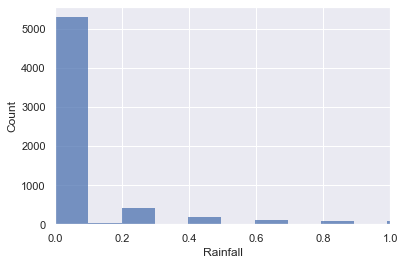

In [15]:
sns.histplot(df.Rainfall)
plt.xlim(0, 1);

# Rainy Days by Location

In [16]:
df_rain_by_loc = df.groupby(by='Location').sum()
df_rain_by_loc = df_rain_by_loc[['RainToday']]
df_rain_by_loc.head()

,RainToday
Location,
Adelaide,44.0
Albury,199.0
Brisbane,135.0
CoffsHarbour,187.0
Darwin,33.0


FileNotFoundError: [Errno 2] No such file or directory: 'images/rainy_days_by_loc.png'

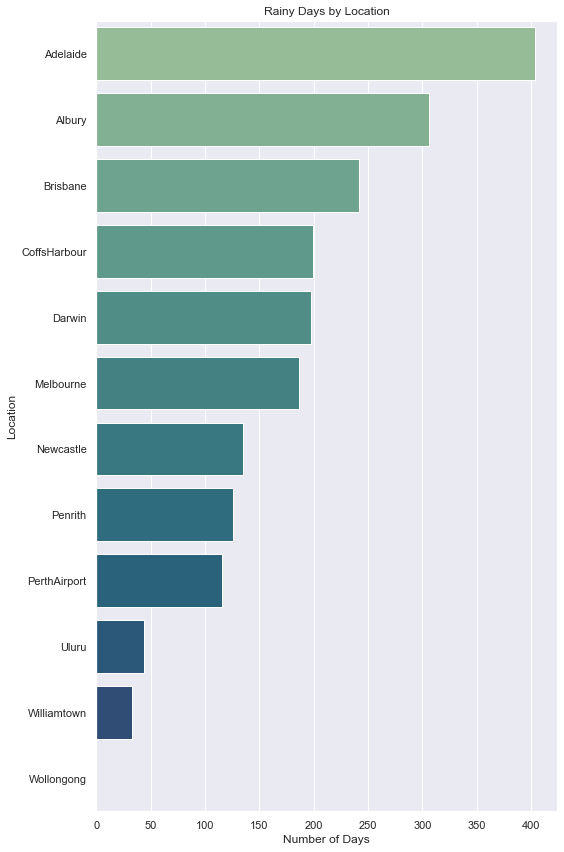

In [17]:
plt.figure(figsize=(8, 12))
sns.barplot(x='RainToday', 
            y=df_rain_by_loc.index, 
            data=df_rain_by_loc.sort_values('RainToday', ascending=False), 
            orient='h',
            palette='crest'
           )
plt.xlabel('Number of Days')
plt.title('Rainy Days by Location')
plt.tight_layout()
plt.savefig('images/rainy_days_by_loc.png', facecolor='white', dpi=100);

In [18]:
df.Location.value_counts()

Melbourne       1622
Williamtown     1230
PerthAirport    1204
Albury           907
Newcastle        822
CoffsHarbour     611
Brisbane         579
Penrith          482
Wollongong       474
Darwin           250
Adelaide         205
Uluru             39
Name: Location, dtype: int64

#   Seasonality
Rainfall exhibits seasonality in many areas of the world. Through grouping the data by month of the year, the percentage of days that it rains in a given month can be easily calculated. Any sort of trend would indicate that the month of the year is a valuable piece of information for modeling purposes.

In [19]:
df_seasonality = df.copy()
df_seasonality['month'] = df_seasonality.Date.apply(lambda x: int(str(x)[5:7]))
df_seasonality[['Date', 'month']].head()

,Date,month
0,2008-12-01,12
1,2008-12-02,12
2,2008-12-03,12
3,2008-12-04,12
4,2008-12-05,12


In [20]:
df_seasonality_grouped = df_seasonality.groupby('month').mean()
df_seasonality_grouped[['RainToday']]

,RainToday
month,
1,0.179487
2,0.272120
3,0.243968
4,0.281090
5,0.211514
6,0.292135
7,0.228095
8,0.263079
9,0.240527


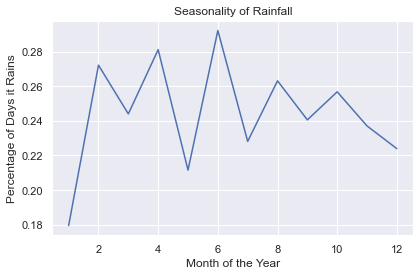

In [85]:
sns.lineplot(data=df_seasonality_grouped, x=df_seasonality_grouped.index, y='RainToday')
plt.title('Seasonality of Rainfall')
plt.xlabel('Month of the Year')
plt.ylabel('Percentage of Days it Rains')
plt.tight_layout()
plt.savefig('images', facecolor='white', dpi=100);

# Correlation Matrix

FileNotFoundError: [Errno 2] No such file or directory: 'images/corr_heatmap.png'

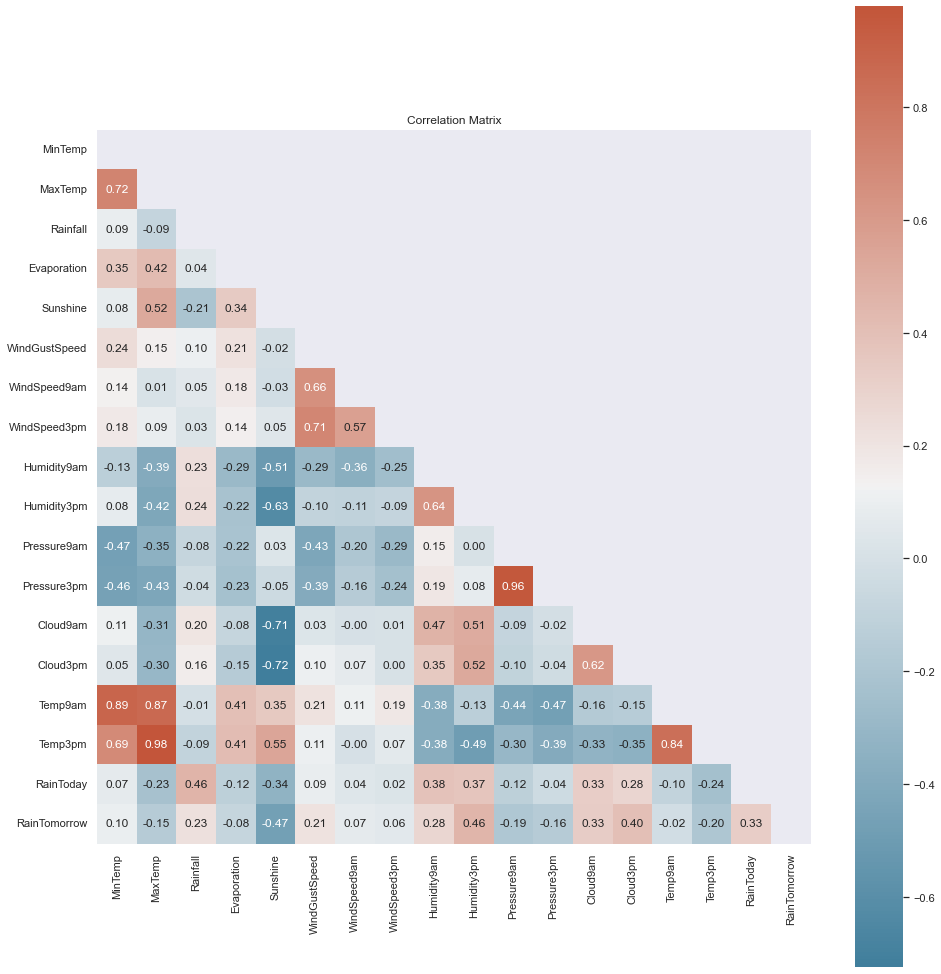

In [22]:
plt.figure(figsize=(14, 14))
plt.title('Correlation Matrix')

# Creating a mask to block the top right half of the heatmap (redundant information)
mask = np.triu(np.ones_like(df.corr()))

# Custom color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', square=True, cmap=cmap)
plt.tight_layout()
plt.savefig('images/corr_heatmap.png', facecolor='white', dpi=100);

# Observations:

* Nothing in this correlation heatmap is surprising
* Features with strong correlations (either positive or negative) have intuitive reasons for being so
# Data Preprocessing

# Missing Values
The primary preprocessing need for this dataset is handling the missing values. Given the strong correlations between certain features, using a multivariate feature imputation method makes sense. While still experimental, the IterativeImputer module from sklearn is perfect for this use case and appears stable enough. This module...

"...models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned."

I do not want to impute values for the target variable (RainTomorrow) since this will detract from the ground truth and have potential negative effects on the model. To start, I'll drop rows in which the RainTomorrow value is missing.

In [23]:
df_imputed = df.dropna(axis=0, subset=['RainTomorrow'])
df_imputed.isna().sum()

Date                0
Location            0
MinTemp            60
MaxTemp            35
Rainfall          107
Evaporation      3419
Sunshine         3880
WindGustDir       953
WindGustSpeed     953
WindDir9am        809
WindDir3pm        286
WindSpeed9am       62
WindSpeed3pm       86
Humidity9am        44
Humidity3pm        83
Pressure9am      1292
Pressure3pm      1293
Cloud9am         2291
Cloud3pm         2331
Temp9am            41
Temp3pm            77
RainToday         107
RainTomorrow        0
dtype: int64

# Continuous Features
For the continuous features, I'll apply the IterativeImputer.

In [24]:
cont_feats = [col for col in df_imputed.columns if df_imputed[col].dtype != object]
cont_feats.remove('RainTomorrow')
cont_feats

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

In [25]:
imputer = IterativeImputer(random_state=42)
df_imputed_cont = imputer.fit_transform(df_imputed[cont_feats])
df_imputed_cont = pd.DataFrame(df_imputed_cont, columns=cont_feats)
df_imputed_cont.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,5.462407,6.498250,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,5.118398,16.9,21.8,0.0
1,7.4,25.1,0.0,5.932122,12.420220,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.023826,1.617162,17.2,24.3,0.0
2,12.9,25.7,0.0,7.357765,11.759469,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,2.121845,2.000000,21.0,23.2,0.0
3,9.2,28.0,0.0,5.323681,12.875563,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.446574,1.046166,18.1,26.5,0.0
4,17.5,32.3,1.0,5.458007,6.284260,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0


In [26]:
df_imputed_cont.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

# Categorical Features
For the categorical features, I'll be replacing the missing values with a randomly chosen option from the unique values of each feature according to their probability distribution.

In [27]:
cat_feats = [col for col in df_imputed.columns if col not in cont_feats]
cat_feats.remove('RainTomorrow')

# Also removing Date and Location since no values are missing
cat_feats.remove('Date')
cat_feats.remove('Location')
cat_feats

['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [28]:
df_imputed_cat = df_imputed[cat_feats]

for col in df_imputed_cat.columns:
    values = df_imputed_cat.WindDir3pm.value_counts().reset_index()['index'].values
    probs = df_imputed_cat[col].value_counts(normalize=True).values
    df_imputed_cat[col].replace(np.nan, np.random.choice(a=values, p=probs), inplace=True)

df_imputed_cat.head()

,WindGustDir,WindDir9am,WindDir3pm
0,W,W,WNW
1,WNW,NNW,WSW
2,WSW,W,WSW
3,NE,SE,E
4,W,ENE,NW


In [29]:
df_imputed_cat.isna().sum()

WindGustDir    0
WindDir9am     0
WindDir3pm     0
dtype: int64

# Concatenating
Now that the missing values have been handled, I need to place all of the separated dataframes back together into one final dataframe.

In [30]:
df_date_loc = df_imputed[['Date', 'Location']]
df_target = df_imputed.RainTomorrow

print(df_date_loc.shape)
print(df_imputed_cont.shape)
print(df_imputed_cat.shape)
print(df_target.shape)

(8186, 2)
(8186, 17)
(8186, 3)
(8186,)


In [31]:
df_imputed_final = pd.concat(objs=[df_date_loc.reset_index(drop=True), 
                                   df_imputed_cont.reset_index(drop=True), 
                                   df_imputed_cat.reset_index(drop=True), 
                                   df_target.reset_index(drop=True)
                                  ], 
                             axis=1
                            )
df_imputed_final.shape

(8186, 23)

In [32]:
df_imputed_final.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,WindGustDir,WindDir9am,WindDir3pm,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,5.462407,6.498250,44.0,20.0,24.0,...,1007.1,8.000000,5.118398,16.9,21.8,0.0,W,W,WNW,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,5.932122,12.420220,44.0,4.0,22.0,...,1007.8,1.023826,1.617162,17.2,24.3,0.0,WNW,NNW,WSW,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,7.357765,11.759469,46.0,19.0,26.0,...,1008.7,2.121845,2.000000,21.0,23.2,0.0,WSW,W,WSW,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,5.323681,12.875563,24.0,11.0,9.0,...,1012.8,0.446574,1.046166,18.1,26.5,0.0,NE,SE,E,0.0
4,2008-12-05,Albury,17.5,32.3,1.0,5.458007,6.284260,41.0,7.0,20.0,...,1006.0,7.000000,8.000000,17.8,29.7,0.0,W,ENE,NW,0.0


A quick check to ensure all missing values have been handled:

In [34]:
df_imputed_final.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
WindGustDir      0
WindDir9am       0
WindDir3pm       0
RainTomorrow     0
dtype: int64

# Extracting the Month
As seen in the EDA section, rainfall in Australia exhibits seasonality. Instead of using the full date from the Date column, extracting just the month is much more valuable.

In [35]:
df_month = df_imputed_final.copy()
df_month.insert(1, 'Month', df_month.Date.apply(lambda x: int(str(x)[5:7])))
df_month.drop(columns='Date', inplace=True)
df_month.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,WindGustDir,WindDir9am,WindDir3pm,RainTomorrow
0,12,Albury,13.4,22.9,0.6,5.462407,6.498250,44.0,20.0,24.0,...,1007.1,8.000000,5.118398,16.9,21.8,0.0,W,W,WNW,0.0
1,12,Albury,7.4,25.1,0.0,5.932122,12.420220,44.0,4.0,22.0,...,1007.8,1.023826,1.617162,17.2,24.3,0.0,WNW,NNW,WSW,0.0
2,12,Albury,12.9,25.7,0.0,7.357765,11.759469,46.0,19.0,26.0,...,1008.7,2.121845,2.000000,21.0,23.2,0.0,WSW,W,WSW,0.0
3,12,Albury,9.2,28.0,0.0,5.323681,12.875563,24.0,11.0,9.0,...,1012.8,0.446574,1.046166,18.1,26.5,0.0,NE,SE,E,0.0
4,12,Albury,17.5,32.3,1.0,5.458007,6.284260,41.0,7.0,20.0,...,1006.0,7.000000,8.000000,17.8,29.7,0.0,W,ENE,NW,0.0


# Dummy Variables
All categorical features now need transformed into dummy variables in order to be useable in the modeling section.

In [36]:
categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_dummies = pd.get_dummies(df_month, columns=categoricals)
df_dummies.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,5.462407,6.498250,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,5.932122,12.420220,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,0.0,7.357765,11.759469,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,0.0,5.323681,12.875563,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,5.458007,6.284260,41.0,7.0,20.0,82.0,33.0,...,0,1,0,0,0,0,0,0,0,0


In [37]:
df_dummies.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Location_Adelaide',
       'Location_Albury', 'Location_Brisbane', 'Location_CoffsHarbour',
       'Location_Darwin', 'Location_Melbourne', 'Location_Newcastle',
       'Location_Penrith', 'Location_PerthAirport', 'Location_Uluru',
       'Location_Williamtown', 'Location_Wollongong', 'WindGustDir_E',
       'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW',
       'WindGustDir_SW', 'WindGustDir_W', 'WindGust

# Modeling

In [38]:
df_final = df_dummies.copy()
X = df_final.drop(columns='RainTomorrow')
y = df_final.RainTomorrow

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size: 6139
Test size:  2047


# Logistic Regression

# Baseline

In [39]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred

array([0., 1., 1., ..., 0., 0., 0.])

Confusion Matrix
-----------------------------------------------------


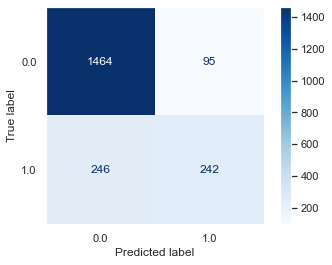



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      1559
         1.0       0.72      0.50      0.59       488

    accuracy                           0.83      2047
   macro avg       0.79      0.72      0.74      2047
weighted avg       0.82      0.83      0.82      2047



ROC Curve
-----------------------------------------------------


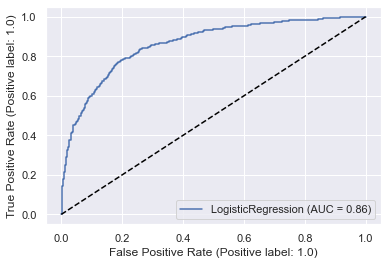



Checking model fitness
-----------------------------------------------------
Train score: 0.8324
Test score:  0.8334




In [40]:
def conf_matrix(model, X_test, y_test, cmap='Blues'):
    plot_confusion_matrix(model, X_test, y_test, cmap=cmap)
    plt.grid()
    plt.show()

def roc_curve_custom(model, X_test, y_test):
    plot_roc_curve(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.show()
    
def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_pred=y_pred):
    # Confusion Matrix
    print('Confusion Matrix')
    print('-'*53)
    conf_matrix(model, X_test, y_test)
    print('\n') 
    
    # Classification Report
    print('Classification Report') 
    print('-'*53)
    print(classification_report(y_test, y_pred))
    print('\n')
    
    # ROC Curve
    print('ROC Curve')
    print('-'*53)
    roc_curve_custom(model, X_test, y_test)
    print('\n')
    
    # Checking model fitness
    print('Checking model fitness') 
    print('-'*53)
    print('Train score:', round(model.score(X_train, y_train), 4))
    print('Test score: ', round(model.score(X_test, y_test), 4))
    print('\n')
    
evaluate(logreg)

# Observations:

* Decent performance for a baseline model
* Recall is the weakest point, particularly for days where it does rain tomorrow
* The model is well fit, with both the train and test scores approximately the same
# Correcting Class Imbalance
* A class imbalance currently exists for the target variable. Correcting for this may help improve model performance. To do so, I will resample the training data using SMOTE.

In [41]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

print('Original')
print('-'*20)
print(y_train.value_counts())
print('\n')
print('SMOTE')
print('-'*20)
print(pd.Series(y_train_resampled).value_counts())

Original
--------------------
0.0    4636
1.0    1503
Name: RainTomorrow, dtype: int64


SMOTE
--------------------
0.0    4636
1.0    4636
Name: RainTomorrow, dtype: int64


In [42]:
logreg_smote = LogisticRegression(random_state=42)
logreg_smote.fit(X_train_resampled, y_train_resampled)
y_pred_smote = logreg_smote.predict(X_test)
y_pred_smote

array([0., 1., 1., ..., 0., 0., 0.])

Confusion Matrix
-----------------------------------------------------


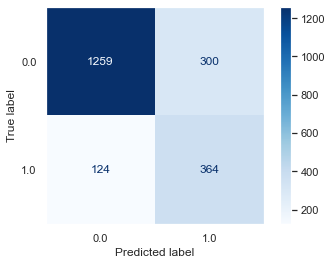



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86      1559
         1.0       0.55      0.75      0.63       488

    accuracy                           0.79      2047
   macro avg       0.73      0.78      0.74      2047
weighted avg       0.82      0.79      0.80      2047



ROC Curve
-----------------------------------------------------


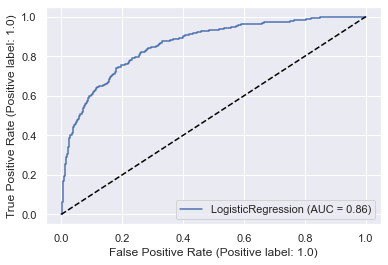



Checking model fitness
-----------------------------------------------------
Train score: 0.7773
Test score:  0.7929




In [43]:
evaluate(logreg_smote, X_train=X_train_resampled, y_train=y_train_resampled, y_pred=y_pred_smote)


# Observations:

* Despite a slight increase in the positive F1 score, the accuracy of this model sharply decreased
* This model remains well fit but scores for both the train and test sets decreased
* Contrary to my initial thoughts, using SMOTE actually had worse performance and will not be utilized in subsequent iterations
# Hyperparameter Tuning


In [46]:
logreg_params = {
    'C': [1, 1e8, 1e16],
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 150],
    'random_state': [42]
}

logreg_gs = GridSearchCV(logreg, logreg_params, scoring='accuracy', cv=3)
logreg_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1, 100000000.0, 1e+16],
                         'fit_intercept': [True, False],
                         'max_iter': [50, 100, 150], 'random_state': [42]},
             scoring='accuracy')

In [49]:
round(logreg_gs.best_score_, 4)

0.8345

In [50]:
y_pred_logreg_gs = logreg_gs.predict(X_test)
y_pred_logreg_gs

array([0., 1., 1., ..., 0., 0., 0.])

Confusion Matrix
-----------------------------------------------------


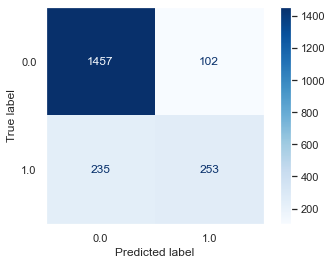



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90      1559
         1.0       0.71      0.52      0.60       488

    accuracy                           0.84      2047
   macro avg       0.79      0.73      0.75      2047
weighted avg       0.83      0.84      0.83      2047



ROC Curve
-----------------------------------------------------


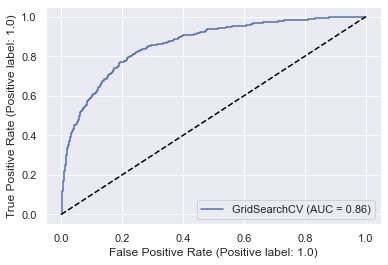



Checking model fitness
-----------------------------------------------------
Train score: 0.8345
Test score:  0.8354




In [51]:
evaluate(logreg_gs, y_pred=y_pred_logreg_gs)

# Observations:

* Slight improvements in precision and model fitness
* Overall, not much improvement over the baseline logreg model
# Decision Tree
# Baseline

In [52]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
y_pred_tree

array([1., 0., 1., ..., 1., 0., 0.])

Confusion Matrix
-----------------------------------------------------


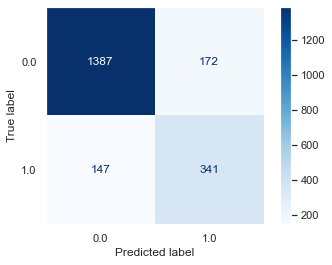



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90      1559
         1.0       0.66      0.70      0.68       488

    accuracy                           0.84      2047
   macro avg       0.78      0.79      0.79      2047
weighted avg       0.85      0.84      0.85      2047



ROC Curve
-----------------------------------------------------


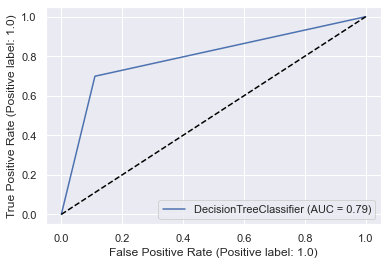



Checking model fitness
-----------------------------------------------------
Train score: 1.0
Test score:  0.8442




In [53]:
evaluate(clf, y_pred=y_pred_tree)

# Observations:

* The accuracy is lower than the tuned logisitic regression model
* The model is overfit, given by the much higher score for the train data versus the test data

# Hyperparameter Tuning


In [54]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 7, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'random_state': [42]
}

clf_gs = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=3)
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 7, 11], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'random_state': [42]},
             scoring='accuracy')

In [56]:
clf_gs.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 42}

In [57]:
round(clf_gs.best_score_, 4)

0.8218

In [58]:
y_pred_tree_gs = clf_gs.best_estimator_.predict(X_test)
y_pred_tree_gs

array([0., 1., 1., ..., 1., 0., 0.])

Confusion Matrix
-----------------------------------------------------


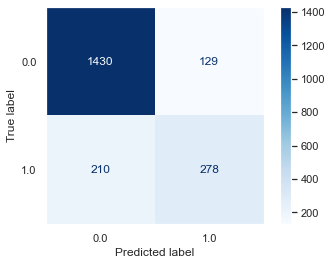



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      1559
         1.0       0.68      0.57      0.62       488

    accuracy                           0.83      2047
   macro avg       0.78      0.74      0.76      2047
weighted avg       0.83      0.83      0.83      2047



ROC Curve
-----------------------------------------------------


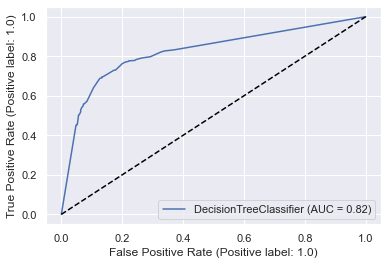



Checking model fitness
-----------------------------------------------------
Train score: 0.9277
Test score:  0.8344




In [59]:
evaluate(clf_gs.best_estimator_, y_pred=y_pred_tree_gs)


# Observations:

* Solid increases in the evaluation metrics
* The tuned model is much better fit than the baseline model which showed overfitness
# Random Forest
# Baseline

In [60]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf

array([0., 0., 1., ..., 1., 0., 0.])

Confusion Matrix
-----------------------------------------------------


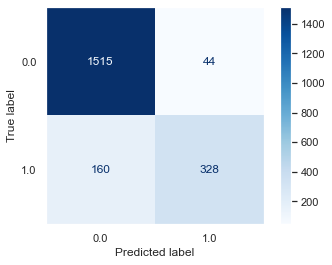



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94      1559
         1.0       0.88      0.67      0.76       488

    accuracy                           0.90      2047
   macro avg       0.89      0.82      0.85      2047
weighted avg       0.90      0.90      0.90      2047



ROC Curve
-----------------------------------------------------


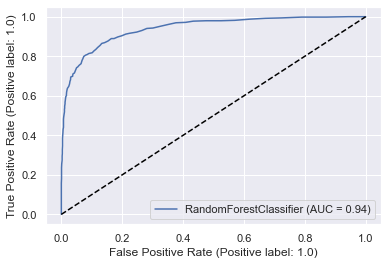



Checking model fitness
-----------------------------------------------------
Train score: 1.0
Test score:  0.9003




In [61]:

evaluate(rf, y_pred=y_pred_rf)

# Observations:

* Good scores on the evaluation metrics
* The model is a bit overfit
# Hyperparameter Tuning

In [62]:
rf_params = {
    'n_estimators': [10, 35, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 7, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'random_state': [42]
}

rf_gs = GridSearchCV(rf, param_grid=rf_params, scoring='accuracy', cv=3)
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 7, 11], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 35, 100], 'random_state': [42]},
             scoring='accuracy')

In [63]:
rf_gs.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 42}

In [64]:
round(rf_gs.best_score_, 4)

0.8554

In [65]:
y_pred_rf_gs = rf_gs.predict(X_test)
y_pred_rf_gs

array([0., 0., 1., ..., 0., 0., 0.])

Confusion Matrix
-----------------------------------------------------


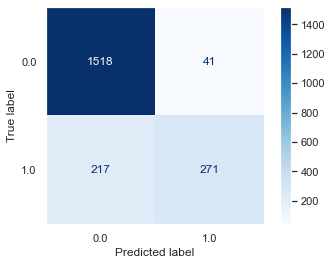



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      1559
         1.0       0.87      0.56      0.68       488

    accuracy                           0.87      2047
   macro avg       0.87      0.76      0.80      2047
weighted avg       0.87      0.87      0.86      2047



ROC Curve
-----------------------------------------------------


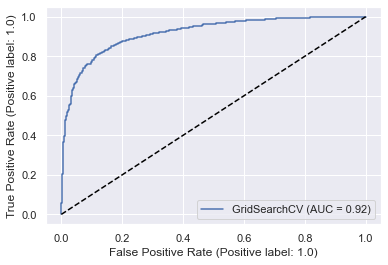



Checking model fitness
-----------------------------------------------------
Train score: 0.929
Test score:  0.874




In [66]:
evaluate(rf_gs, y_pred=y_pred_rf_gs)

# Observations:

* The accuracy score remained roughly the same while the F1 score decreased
* Small increase in the AUC of the ROC curve
* Furthermore, the tuned model has a much better fit than the baseline model

# XGBoost
* Baseline

In [67]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb

[23:35:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([1., 0., 1., ..., 1., 0., 0.])

Confusion Matrix
-----------------------------------------------------


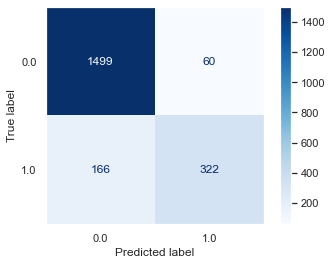



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      1559
         1.0       0.84      0.66      0.74       488

    accuracy                           0.89      2047
   macro avg       0.87      0.81      0.84      2047
weighted avg       0.89      0.89      0.88      2047



ROC Curve
-----------------------------------------------------


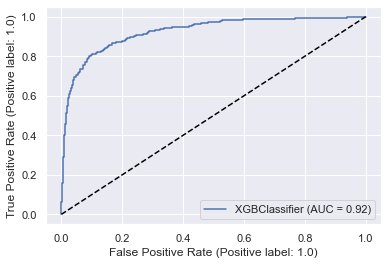



Checking model fitness
-----------------------------------------------------
Train score: 0.9984
Test score:  0.8896




In [68]:
evaluate(xgb, y_pred=y_pred_xgb)

# Observations:

* Highest accuracy score yet
* Highest AUC yet
* The model is decently fit
# Hyperparameter Tuning

In [69]:
xgb_params = {
    'n_estimators': [10, 35, 100],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.25]
}

xgb_gs = GridSearchCV(xgb, xgb_params, scoring='accuracy', cv=3)
xgb_gs.fit(X_train, y_train)

[23:35:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:35:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:35:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:35:21] WARNING:

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=2,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None),
             param_grid={'learning_rate': [0.01, 0.1, 0.25],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [10, 35, 100]},
             scoring='accuracy')

In [70]:
xgb_gs.best_params_

{'learning_rate': 0.25, 'max_depth': 15, 'n_estimators': 100}

In [71]:
round(xgb_gs.best_score_, 4)

0.8689

In [72]:
y_pred_xgb_gs = xgb_gs.predict(X_test)
y_pred_xgb_gs

array([0., 0., 1., ..., 1., 0., 0.])

Confusion Matrix
-----------------------------------------------------


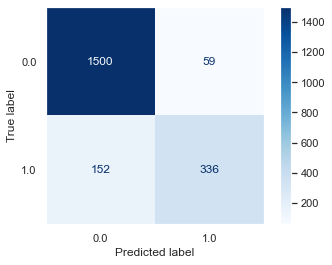



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93      1559
         1.0       0.85      0.69      0.76       488

    accuracy                           0.90      2047
   macro avg       0.88      0.83      0.85      2047
weighted avg       0.89      0.90      0.89      2047



ROC Curve
-----------------------------------------------------


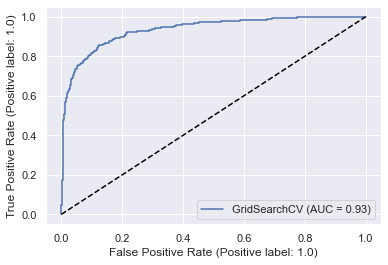



Checking model fitness
-----------------------------------------------------
Train score: 1.0
Test score:  0.8969




In [73]:
evaluate(xgb_gs, y_pred=y_pred_xgb_gs)

# Observations:

* Slight improvement in some metrics but largely the same
* AUC remains the same
* Model fitness slightly decreased
* Overall, not much of an impact
# Feature Importances
* Since this model achieved the best results, I want to explore the feature importances a bit more in depth.

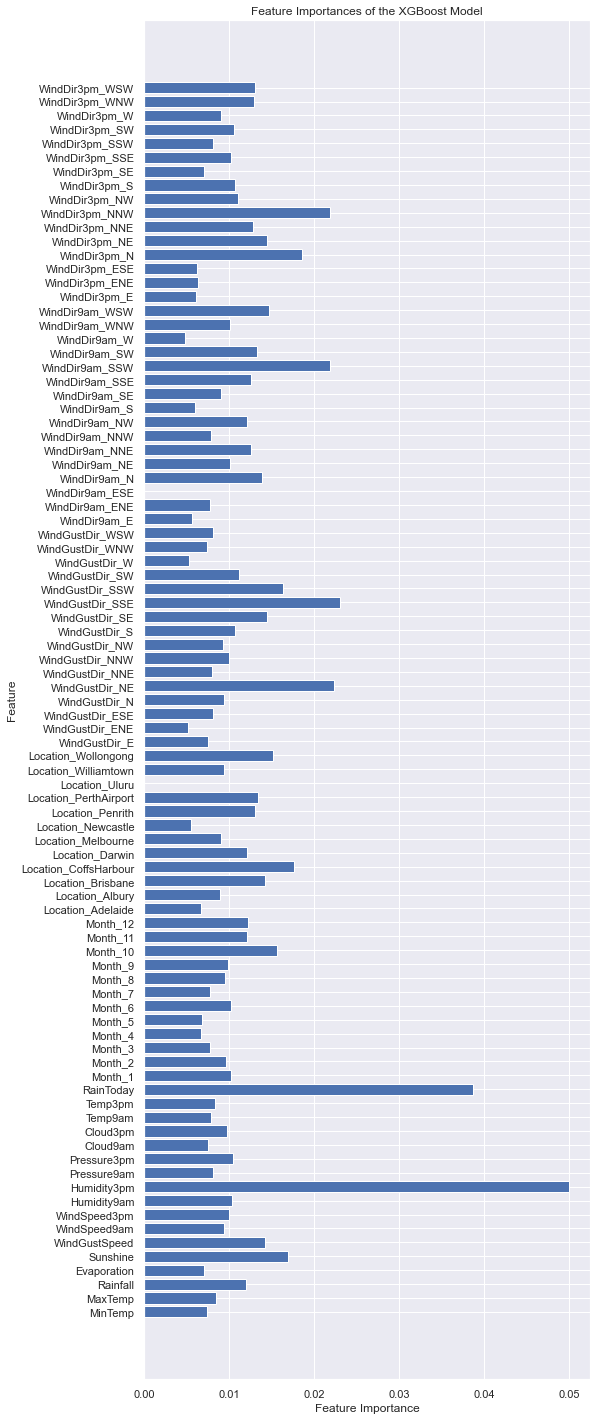

In [74]:
best_xgb = xgb_gs.best_estimator_

plt.figure(figsize=(8, 25))
plt.barh(range(best_xgb.n_features_in_), best_xgb.feature_importances_)
plt.yticks(np.arange(best_xgb.n_features_in_), X_train.columns.values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of the XGBoost Model');

Although the dummy variables were necessary for modeling the data, they are not conducive to analyzing the feature importances. As a result, I need to regroup the data into their primary categories to aggregate their category-level importances.

In [75]:
feat_imp_df = pd.DataFrame(data={'Feature': df_final.columns.drop('RainTomorrow'),
                                 'Importance': best_xgb.feature_importances_
                                }
                           )
feat_imp_df['Group'] = feat_imp_df.Feature.apply(lambda x: x.split('_')[0])
feat_imp_df

,Feature,Importance,Group
0,MinTemp,0.007407,MinTemp
1,MaxTemp,0.008493,MaxTemp
2,Rainfall,0.012049,Rainfall
3,Evaporation,0.007120,Evaporation
4,Sunshine,0.016909,Sunshine
...,...,...,...
84,WindDir3pm_SSW,0.008159,WindDir3pm
85,WindDir3pm_SW,0.010617,WindDir3pm
86,WindDir3pm_W,0.009117,WindDir3pm
87,WindDir3pm_WNW,0.012987,WindDir3pm


In [76]:
feat_imp_df.Group.value_counts()

WindDir3pm       16
WindDir9am       16
WindGustDir      16
Location         12
Month            12
MaxTemp           1
RainToday         1
Temp3pm           1
Temp9am           1
Cloud3pm          1
Cloud9am          1
MinTemp           1
Pressure9am       1
Humidity3pm       1
Humidity9am       1
WindSpeed3pm      1
WindSpeed9am      1
WindGustSpeed     1
Sunshine          1
Evaporation       1
Rainfall          1
Pressure3pm       1
Name: Group, dtype: int64

* These value counts align with the number of unique values for the categorical columns in the original dataframe (excluding Month which was engineered later), meaning the lambda function worked as expected.

In [78]:
feat_imp_df_grouped = feat_imp_df.groupby(by='Group').sum()
feat_imp_df_grouped.sort_values('Importance', ascending=False, inplace=True)
feat_imp_df_grouped

,Importance
Group,
WindDir3pm,0.179647
WindGustDir,0.176552
WindDir9am,0.162607
Location,0.125461
Month,0.118716
Humidity3pm,0.050031
RainToday,0.038671
Sunshine,0.016909
WindGustSpeed,0.014289


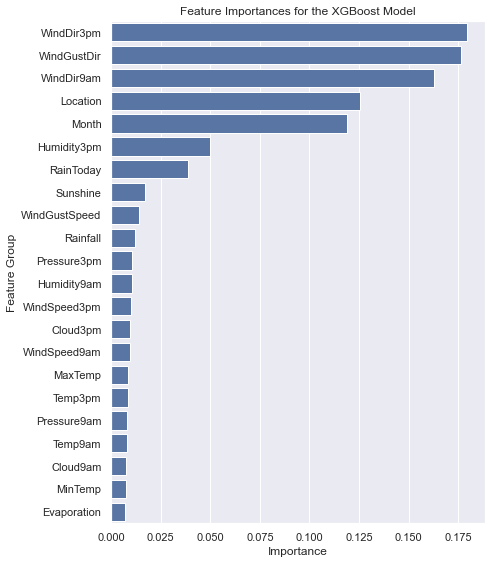

In [84]:
plt.figure(figsize=(7, 8))
sns.barplot(y=feat_imp_df_grouped.index,
            x=feat_imp_df_grouped.Importance,
            orient='h',
            color=sns.color_palette()[0]
           )
plt.title('Feature Importances for the XGBoost Model')
plt.ylabel('Feature Group')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('images', facecolor='white', dpi=100);

# Model Comparisons


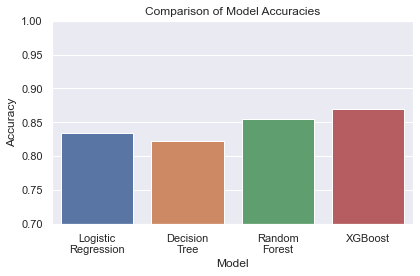

In [83]:
models = [logreg_gs, clf_gs, rf_gs, xgb_gs]

sns.barplot(x=['Logistic\nRegression', 'Decision\nTree', 'Random\nForest', 'XGBoost'],
            y=[model.best_score_ for model in models]
           )
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.title('Comparison of Model Accuracies')
plt.tight_layout()
plt.savefig('images', facecolor='white', dpi=100);

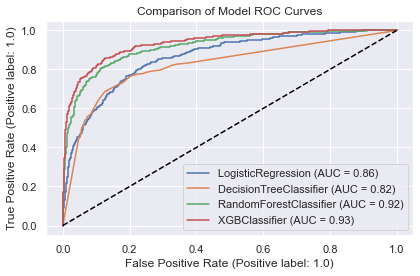

In [82]:
fig, ax = plt.subplots()
for model in models:
    plot_roc_curve(model, 
                   X_test, 
                   y_test,
                   name=type(model.best_estimator_).__name__,
                   ax=ax
                  )
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Comparison of Model ROC Curves')
plt.tight_layout()
plt.savefig('images', facecolor='white', dpi=100);

# Conclusion
# Results
The best performing model is the hyperparameter-tuned XGBoost model with an accuracy of approximately 86%. The scores for both the training and testing data were similar, reducing concerns of the model being overfit. In terms of feature importances, Humidity3pm is the single most important feature. However, when grouping the features back into their original categories, the following groups have the most importance:

* Location
* WindDir3pm
* WindDir9am
* WindGustDir
* Month
* Humidity3pm
# Next Steps
While this model is a good starting point for rain prediction in Australia, there are several ways in which the model could be improved upon:

* Further hyperparameter tuning
* Engineering new features such as trailing amounts of rain or sunshine
* Collecting additional data from nearby countries (for example, does rain originating in Indonesia or New Zealand have predictive power?)
* Attempting to predict the amount of rainfall